## Create CSV files for AnDA - version 2

Objectives: 

- Open IBTrACS, filter it and interpolate data such that time step is every hour. 

- Then, for each storm, find all collocated SAR, RAD and SCT data, and add it to the timestep.

CAVEAT: I need to pay attention on how I interpolate longitudes. Also, I didn't select latitude < 30° so far.

TODO: Add a column for time. interpolate to 1h timesteps. Add observations to closest timesteps. 

In [1]:
# General
import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime

# Custom
import functions as f
import dataUtils as du

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PATHS  = {
    'obs_dir':     '/home/arthur/results/ck22model/Radiometer_applications/02_inferences/obs_nc_files/',
    'ibt_pth':     '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc',
    'sav_csv_dir': '/home/arthur/scripts/TCsLifeMonitFromObs/AnDA/AnDA_data/IBTrACS_V9/',
    'sav_fig_dir': '/home/arthur/results/TCsLifeMonitFromObs/00_create_csv_AnDA_v02/'
}

PARAMS = {
    'csv_vars2keep':  ['usa_wind', 'usa_rmw', 'rmx_ck22', 'mean_r34', 'fcor'],
    'csv_var_names':  ['Vmax',     'Rmax',    'rmx_ck22', 'R34',      'fcor'],
    'ibt_vars2keep':  ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw', 'storm_speed', 'storm_dir', 'name', 'sid'],
    'ibt_info2keep':  ['sid', 'basin', 'name', 'usa_atcf_id', 'usa_agency', 'iso_time', 'usa_status'],
    'LMI_min':        33,  # If a storm doesn't reach LMI_min m/s along its life cycle, it is discarded
    'min_valid_rmxs': 24,  # If a storm has less than min_valid_rmxs timesteps with valid values of usa_rmw, it is discarded
    'min_seq_len':    24,  # If a storm has less than 24 valid timesteps IN A ROW for usa_wind, usa_rmw, and mean_r34 after selecting 17.5 ms < t < LMI, it is discarded
    'save_csv_files': False, 
    'save_figs':      False,
}

In [3]:
### OPEN IBTrACS
ds_ibt_raw = xr.open_dataset(PATHS['ibt_pth'])
ds_ibt     = ds_ibt_raw[PARAMS['ibt_vars2keep']]
ds_ibt[PARAMS['ibt_info2keep']] = ds_ibt_raw[PARAMS['ibt_info2keep']].astype(str, copy=False) # Convert byte arrays to strings

start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))

In [4]:
### CONVERSIONS
# Convert to m/s and km units
for speed in ['usa_wind', 'storm_speed']:
    ds_ibt[speed]  *= 0.5144
    ds_ibt[speed].attrs['units'] = 'm/s (original units from IBTrACS file: kts)'
for radius in ['usa_r34', 'usa_rmw']:
    ds_ibt[radius] *= 1.852
    ds_ibt[radius].attrs['units'] = 'km (original units from IBTrACS file: n. mi)'

In [5]:
### IBTrACS interpolation
# How to handle angles before interpolation
def shortest_angle(angle_diff):
    '''Given an angle_diff end - start between 2 angles, returns the shortest angle between 0 and 360 to go from start to end.'''
    return ((angle_diff) + 180) % 360 - 180

def rearange(da):
    '''Given a dataArray of angles, reorganizes the angle values so that there is no jump.
    For instance, given a sequence of angles [358, 359, 0, 1, 2], reorganizes that sequence into [358, 359, 360, 361, 362].
    So that it can further be interpolated correctly: 1st apply this function. 2nd interpolate. 3rd apply modulo 360 to be consistent with the rest.
    NB: John has a solution based on decomposing the angles on cosine and sine, then interpolating, anf finally taking the arctan2 of the ratio.
    NB2: We could also detect the basin in which the storm is, and select an interval (e.g [-180, 180]) that works for each specific basin.
    '''              
    dav     = da.dropna(dim='date_time')
    dav[1:] = shortest_angle(dav.diff(dim='date_time')) # Compute the discrete shortest angle difference between all angles 2 by 2 but let the first valid value intact
    da[da.notnull()] = dav.cumsum(dim='date_time')      # Cumulative sum: starts from the 1st number then add all the differences previously computed step by step
    return da

In [6]:
### 1) LMI >= 33 m/s
ds_ibt['LMI_is_above_33ms'] = xr.DataArray(np.zeros_like(ds_ibt.storm), dims={'storm': ds_ibt.storm})
msk = ds_ibt.usa_wind.max(dim='date_time', skipna=True) < PARAMS['LMI_min'] 
ds_ibt.LMI_is_above_33ms[~msk] = 1
ds_ibt = ds_ibt.where(ds_ibt.LMI_is_above_33ms == 1, drop=True)

### 2) At least 24 valid Rmax values
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_rmw']
    if np.count_nonzero(~np.isnan(da)) < PARAMS['min_valid_rmxs']: # Count the number of valid usa_rmw values and filter it out if less than 24 values
        ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 

print("Total samples after removing LMI < {} m/s and nb of valid values for Rmax > {}: ".format(PARAMS['LMI_min'], PARAMS['min_valid_rmxs']), len(ds_ibt['storm']))

### 3) Add nb_of_hours since 17.5 m/s have been achieved
ds_ibt['i17ms'] = xr.DataArray(np.zeros_like(ds_ibt.storm), dims={'storm': ds_ibt.storm})
ds_ibt['t17ms'] = xr.DataArray(np.tile(None, ds_ibt.storm.shape), dims={'storm': ds_ibt.storm}).astype("datetime64[ns]")
ds_ibt['h17ms'] = xr.DataArray(np.zeros_like(ds_ibt.usa_lon),     dims={'storm': ds_ibt.storm, 'date_time': ds_ibt.date_time})
for s in tqdm(range(len(ds_ibt.storm))):
    ds  = ds_ibt.isel(storm=s)
    i17 = int(ds.date_time.where(ds.usa_wind > 17.5, drop=True)[0])
    ds_ibt['i17ms'][s] = i17
    ds_ibt['t17ms'][s] = ds.time[i17] # CAVEAT: If a time serie starts with usa_wind > 17.5 m/s, t17 will still be ds.time[0]
    ds_ibt['h17ms'][s] = (ds.time - ds.time[i17]).astype(float) / (1e9) / 3600
    ds_ibt['h17ms'][s][np.isnat(ds.time)] = np.nan
    
print('h17ms successfully computed.')

### 4) Crop dataset between 17.5 ms and LMI
ds_ibt['hLMI'] = xr.DataArray(np.zeros_like(ds_ibt.usa_lon), dims={'storm': ds_ibt.storm, 'date_time': ds_ibt.date_time})
ds_ibt['iLMI'] = ds_ibt.usa_wind.argmax(dim='date_time')
for s in tqdm(range(len(ds_ibt.storm))):
    ds = ds_ibt.isel(storm=s)
    ds_ibt['usa_wind'][s, :int(ds.i17ms)] = np.nan
    ds_ibt['usa_wind'][s, int(ds.iLMI):]  = np.nan
    if np.count_nonzero(ds_ibt['usa_wind'][s].notnull()) < PARAMS['min_seq_len']:
        ds_ibt['usa_wind'][s] = np.nan
    # Also, add hLMI (just for reference):
    ds_ibt['hLMI'][s] = (ds.time - ds.time[int(ds_ibt['iLMI'][s])]).astype(float) / (1e9) / 3600
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) 

print('Total samples after selecting 17.5 m/s < t < LMI and keeping sequences that have more than {} valid timesteps:'.format(PARAMS['min_seq_len']), len(ds_ibt['storm']))

### 5) Add R34 and Coriolis parameter
ds_ibt['mean_r34'] = ds_ibt.usa_r34.mean(dim='quadrant', skipna=True)
ds_ibt['fcor']     = f.coriolis(np.abs(ds_ibt['usa_lat']))

### 6) Attributes
ds_ibt.LMI_is_above_33ms.attrs['description'] = 'A simple boolean (0 or 1) to say whether storm LMI is above 33 m/s (1) or not (0)'
ds_ibt.i17ms.attrs['description'] = 'Index of the date_time dimension when storm has reached 17.5 m/s'
ds_ibt.t17ms.attrs['description'] = 'UTC time of when storm has reached 17.5 m/s'
ds_ibt.h17ms.attrs['description'] = 'Time difference (in hours) between current time step and t17ms: t_current - t17ms'
ds_ibt.iLMI.attrs['description']  = 'Index of the date_time dimension when storm has reached LMI'
ds_ibt.hLMI.attrs['description']  = 'Time difference (in hours) between current time step and LMI: t_current - tLMI'
ds_ibt.fcor.attrs['description']  = 'Average of the quadrant values of R34 in the IBTrACS, eventually skipping NaNs'
ds_ibt.fcor.attrs['description']  = 'Coriolis parameter computed at the absolute value of the latitude, hence always positive'

### 7) Assign Rmax CK22
ds_ibt['rmx_ck22'] = f.get_rmax_ck22(ds_ibt['usa_wind'], ds_ibt['mean_r34'], ds_ibt['fcor'], 0.608, -0.00767, -0.00183) / 1000 # Coefficients of the paper

# ### 4) FLIP TCs of Southern hemisphere
# ### Take the symmetric with respect to Equator
# ### So storm_dir = PI - storm_dir
# ds_ibt.where(ds_ibt['lat'] < 0)['storm_dir'] = 180 - ds_ibt['storm_dir']
# # Then project to (u, v) ref.
# ds_ibt['u_trans'] = ds_ibt['storm_speed'] * np.sin(np.deg2rad(ds_ibt['storm_dir']))
# ds_ibt['v_trans'] = ds_ibt['storm_speed'] * np.cos(np.deg2rad(ds_ibt['storm_dir']))
# # plt.hist(np.array(ds_ibt['u_trans']).flatten()) # Check gaussianity

  0%|          | 0/1152 [00:00<?, ?it/s]

Total samples after removing LMI < 33 m/s and nb of valid values for Rmax > 24:  866


  0%|          | 0/866 [00:00<?, ?it/s]

h17ms successfully computed.


  0%|          | 0/866 [00:00<?, ?it/s]

Total samples after selecting 17.5 m/s < t < LMI and keeping sequences that have more than 24 valid timesteps: 432


In [7]:
# ds_ibt = ds_ibt.where(ds_ibt.name == 'SOUDELOR', drop=True)
# ds_ibt = ds_ibt.isel(storm=slice(100, 200))

In [8]:
def is_sar_or_not(path):
    'Returns 1 if SAR data, 0 if not'
    if path.split('/')[5] in ['radiometer', 'KNMI']:
        return 0
    else:
        return 1

In [9]:
nb_files = 0
datasets = []

### CREATE CSV FILES
for s in tqdm(range(len(ds_ibt.storm))):
    ds  = ds_ibt.isel(storm=s)
    I_MIN = 0
    I_MAX = 359
    for param in PARAMS['csv_vars2keep']:
        i_min = int(ds.date_time[~np.isnan(ds[param])].min())
        i_max = int(ds.date_time[~np.isnan(ds[param])].max())
        if i_min > I_MIN:
            I_MIN = i_min
        if i_max < I_MAX:
            I_MAX = i_max
    ds = ds.isel(date_time=slice(I_MIN, I_MAX))
    
    ### CHECK AND FILTER
    discard = False
    # At least 24 valid values in a row
    for param in ['usa_wind', 'usa_rmw', 'mean_r34', 'fcor']:
        if np.count_nonzero(np.isnan(ds[param])) > 0:
            val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
            if val_len < PARAMS['min_seq_len']:
                discard = True
    if len(ds.date_time) < PARAMS['min_seq_len']:
        discard = True
    # Every timestep must be a 3-hr timestep
    if ds.h17ms.diff(dim='date_time').max(skipna=True) !=3 and not discard:
        print('CAVEAT: Storm {} does not have 3-hrs timesteps. Storm discarded'.format(s))
        discard = True
    
    # If there still is a nan after all this discard the sample
    ds2keep = ds[PARAMS['csv_vars2keep']]
    if np.count_nonzero(np.isnan(ds2keep.to_array())) > 0:
        discard = True
        
    
    if not discard:
        nb_files += 1
        
        # Add observations
        # Initialize empty arrays of observations and store observations in ds
        # Observations will be added later to ds2keep
        for p in ['vmx_obs', 'rmx_obs', 'r34_obs', 'vmx_sar', 'rmx_sar', 'r34_sar']:
            ds[p] = xr.DataArray(np.full_like(ds.usa_wind, fill_value=np.nan), dims={'date_time': ds_ibt.time})
        TCf = '{}_{}'.format(np.unique(ds.usa_atcf_id)[0].lower(), ds.name.data)
        # Open observations if exist
        if os.path.exists(PATHS['obs_dir'] + TCf):
            ds_obs = xr.open_dataset(PATHS['obs_dir'] + TCf)
            ds_obs['is_sar'] = xr.DataArray(np.array([is_sar_or_not(str(p.data)) for p in ds_obs.pth]), coords={'time': ds_obs.time}) # Separate data: 1 if SAR, 0 if not
            for is_sar, dss in ds_obs.groupby(ds_obs.is_sar): 
                # Iterate over ds_obs, eventually fill observations
                for i_o, t in enumerate(dss.time):
                    t_dffs         = (t - ds.time) / np.timedelta64(1, 'h')
                    idx_min, t_dff = np.nanargmin(abs(t_dffs)), np.nanmin(abs(t_dffs))
                    if t_dff < 1.5:
                        for p in ['vmx', 'rmx', 'r34']:
                            if is_sar == 0: # Radiometer, scatterometer
                                ds['{}_obs'.format(p)][idx_min] = dss.isel(time=i_o)[p]
                            if is_sar == 1: # SAR
                                ds['{}_sar'.format(p)][idx_min] = dss.isel(time=i_o)[p]
                               
            # To do later tests              
            datasets.append(ds)
        
        # SAVE CSV
        if PARAMS['save_csv_files']:
            df      = pd.DataFrame(
                data=ds2keep.to_array().transpose(),
                columns=PARAMS['csv_var_names']
            )
            for p in ['vmx_obs', 'rmx_obs', 'r34_obs', 'vmx_sar', 'rmx_sar', 'r34_sar']:
                df[p] = np.array(ds[p])
            df.index = pd.to_datetime(ds2keep.time)
            df.index.name = 'Time'
            df.to_csv(PATHS['sav_csv_dir'] + '{}_{}'.format(np.unique(ds.usa_atcf_id)[0].lower(), ds.name.data))
        
        # PLOT
        if PARAMS['save_figs']:
            fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
            for param, ax in zip(PARAMS['csv_vars2keep'], fig.axes):
                ax.set_title(param, weight='bold')
                ax.plot(ds.time, ds[param])
                ax.grid()
                ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%m-%d"))
            plt.savefig(PATHS['sav_fig_dir'] + TCf, bbox_inches = 'tight');plt.clf()
            
print('Total nb. of files: {}'.format(nb_files))

  0%|          | 0/432 [00:00<?, ?it/s]

CAVEAT: Storm 19 does not have 3-hrs timesteps. Storm discarded
Total nb. of files: 285


In [31]:
### TESTS

In [19]:
# RAD, SCT, and SAR
print('Nb. of datasets: ', len(datasets))
ds_glob = xr.concat(datasets, dim='date_time')

hLMIs = np.arange(-99, 0, 3)
keys  = ['vmx_obs', 'rmx_obs', 'r34_obs', 'vmx_sar', 'rmx_sar', 'r34_sar']
MEAN  = dict.fromkeys(keys)
CNTS  = dict.fromkeys(keys)

for key in keys:
    MEAN[key] = np.array([float(ds_glob.where(ds_glob.hLMI == h, drop=True)[key].mean(dim='date_time', skipna=True)) for h in hLMIs])
    CNTS[key] = np.array([float(np.count_nonzero(~np.isnan(ds_glob.where(ds_glob.hLMI == h, drop=True)[key]))) for h in hLMIs])

Nb. of datasets:  189


In [73]:
# IBTrACS
ibt_keys     = ['vmx_ibt',  'rmx_ibt', 'r34_ibt']
ibt_dsg_keys = ['usa_wind', 'usa_rmw', 'mean_r34']

for ibt_key, ibt_dsg_key in zip(ibt_keys, ibt_dsg_keys):
    MEAN[ibt_key] = np.array([float(ds_glob.where(ds_glob.hLMI == h, drop=True)[ibt_dsg_key].mean(dim='date_time', skipna=True)) for h in hLMIs])
    CNTS[ibt_key] = np.array([float(np.count_nonzero(~np.isnan(ds_glob.where(ds_glob.hLMI == h, drop=True)[ibt_dsg_key]))) for h in hLMIs])

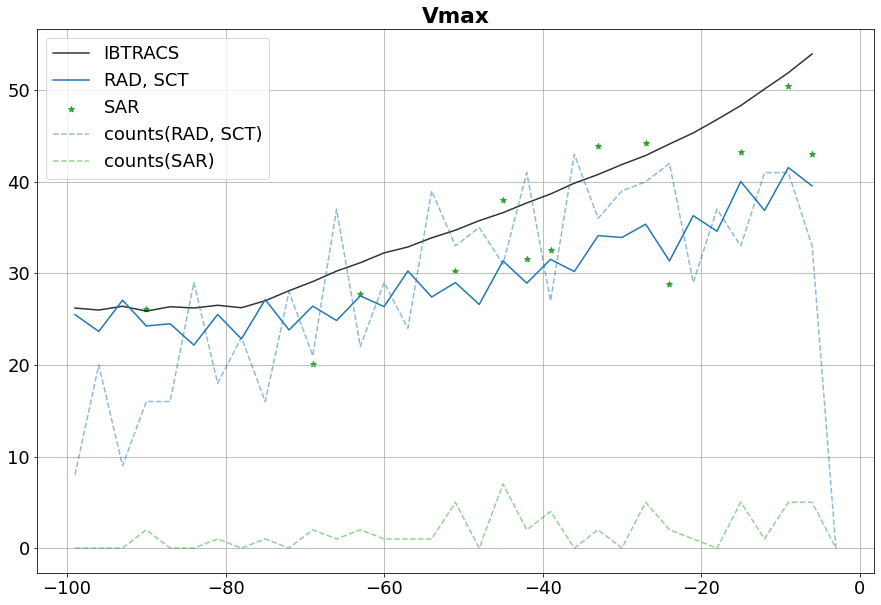

In [89]:
msk = CNTS['vmx_sar'] >= 2 # Eventual mask for SAR data

plt.title('Vmax', weight='bold')
plt.plot(hLMIs[:-1], MEAN['vmx_ibt'][:-1],label='IBTRACS',    c='k', alpha=0.8)
plt.plot(hLMIs, MEAN['vmx_obs'],    label='RAD, SCT',         c='tab:blue')
plt.scatter(hLMIs[msk], MEAN['vmx_sar'][msk], label='SAR',    c='tab:green', marker='*')
plt.plot(hLMIs, CNTS['vmx_obs'],    label='counts(RAD, SCT)', c='tab:blue',  linestyle='--', alpha=0.5)
plt.plot(hLMIs, CNTS['vmx_sar'],    label='counts(SAR)',      c='tab:green', linestyle='--', alpha=0.5)
plt.legend();plt.grid()

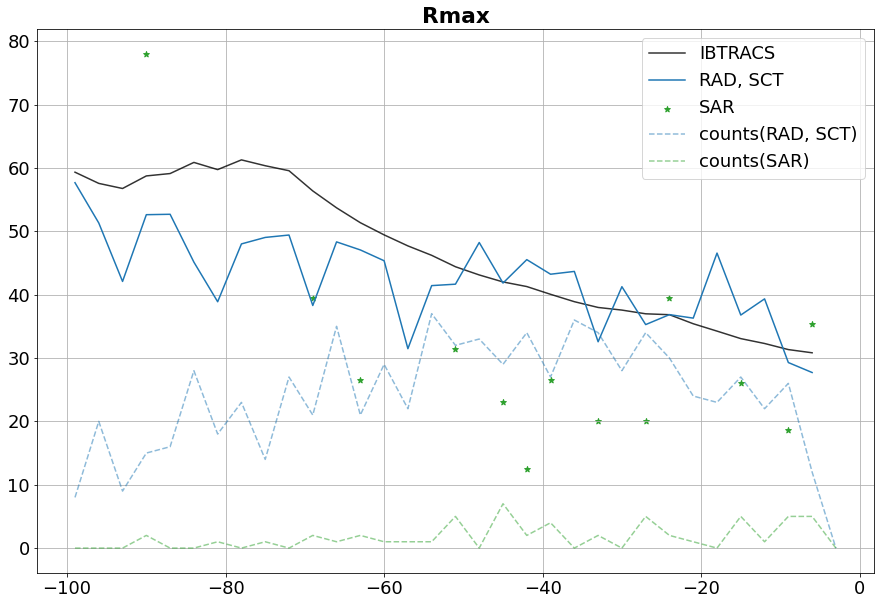

In [87]:
msk = CNTS['rmx_sar'] >= 2 # Eventual mask for SAR data

plt.title('Rmax', weight='bold')
plt.plot(hLMIs[:-1], MEAN['rmx_ibt'][:-1],label='IBTRACS',    c='k', alpha=0.8)
plt.plot(hLMIs, MEAN['rmx_obs'],    label='RAD, SCT')
plt.scatter(hLMIs[msk], MEAN['rmx_sar'][msk], label='SAR',    c='tab:green', marker='*')
plt.plot(hLMIs, CNTS['rmx_obs'],    label='counts(RAD, SCT)', c='tab:blue',  linestyle='--', alpha=0.5)
plt.plot(hLMIs, CNTS['rmx_sar'],    label='counts(SAR)',      c='tab:green', linestyle='--', alpha=0.5)
plt.legend();plt.grid()

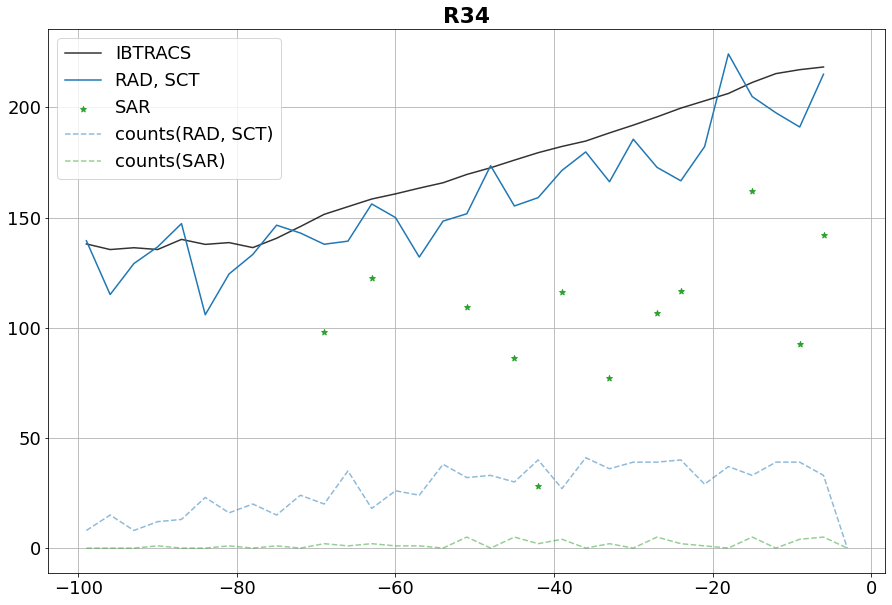

In [88]:
msk = CNTS['r34_sar'] >= 2 # Eventual mask for SAR data

plt.title('R34', weight='bold')
plt.plot(hLMIs[:-1], MEAN['r34_ibt'][:-1],label='IBTRACS',    c='k', alpha=0.8)
plt.plot(hLMIs, MEAN['r34_obs'],    label='RAD, SCT')
plt.scatter(hLMIs[msk], MEAN['r34_sar'][msk], label='SAR',    c='tab:green', marker='*')
plt.plot(hLMIs, CNTS['r34_obs'],    label='counts(RAD, SCT)', c='tab:blue',  linestyle='--', alpha=0.5)
plt.plot(hLMIs, CNTS['r34_sar'],    label='counts(SAR)',      c='tab:green', linestyle='--', alpha=0.5)
plt.legend();plt.grid()

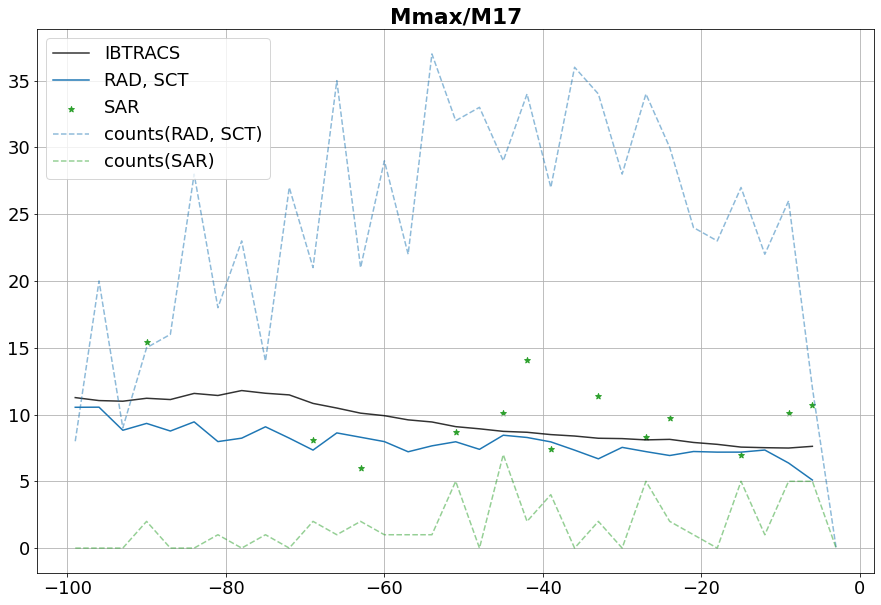

In [90]:
msk = CNTS['rmx_sar'] >= 2 # Eventual mask for SAR data
rat_obs = MEAN['vmx_obs'] * MEAN['rmx_obs'] / MEAN['r34_obs']
rat_sar = MEAN['vmx_sar'] * MEAN['rmx_sar'] / MEAN['r34_sar']
rat_ibt = MEAN['vmx_ibt'] * MEAN['rmx_ibt'] / MEAN['r34_ibt']

plt.title('Mmax/M17', weight='bold')
plt.plot(hLMIs[:-1], rat_ibt[:-1],label='IBTRACS',    c='k', alpha=0.8)
plt.plot(hLMIs, rat_obs,    label='RAD, SCT')
plt.scatter(hLMIs[msk], rat_sar[msk], label='SAR',            c='tab:green', marker='*')
plt.plot(hLMIs, CNTS['rmx_obs'],    label='counts(RAD, SCT)', c='tab:blue',  linestyle='--', alpha=0.5)
plt.plot(hLMIs, CNTS['rmx_sar'],    label='counts(SAR)',      c='tab:green', linestyle='--', alpha=0.5)
plt.legend();plt.grid()

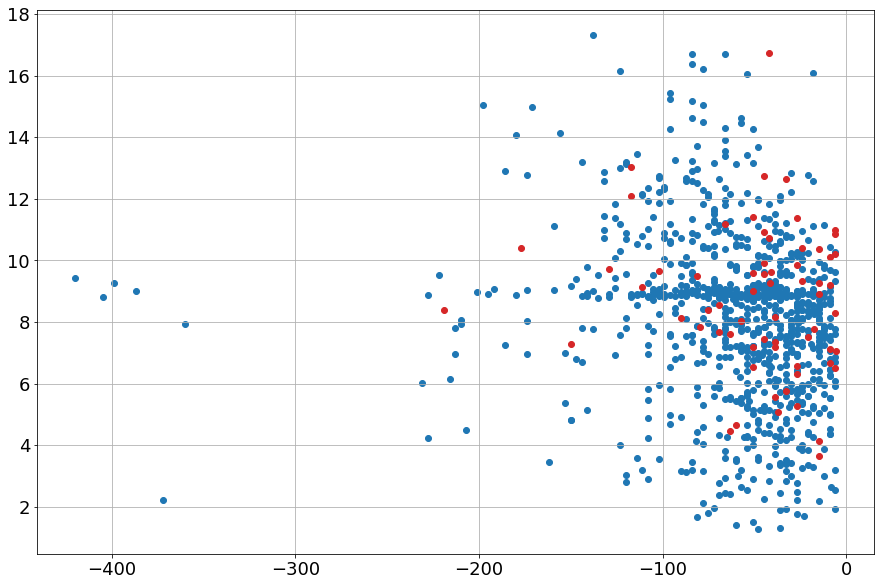

In [26]:
rat_obs = ds_glob.vmx_obs * ds_glob.rmx_obs / ds_glob.r34_obs
rat_sar = ds_glob.vmx_sar * ds_glob.rmx_sar / ds_glob.r34_sar
rat_ibt = ds_glob.usa_wind * ds_glob.usa_rmw / ds_glob.mean_r34

plt.scatter(ds_glob.hLMI, rat_obs, c='tab:blue');plt.grid()
plt.scatter(ds_glob.hLMI, rat_sar, c='tab:red')
# plt.scatter(ds_glob.hLMI, rat_ibt, c='tab:green', alpha=0.05)